<a href="https://colab.research.google.com/github/rahulrainarr/mycode/blob/main/India_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TA-Lib not available. Using manual calculations for technical indicators.
Enhanced Indian Stock Market Prediction Model
Enter NSE/BSE stock ticker (e.g., TCS.NS, RELIANCE.NS): reliance.ns
✅ Downloaded 1384 trading days of data for reliance.ns
📊 Available columns: ['Close', 'High', 'Low', 'Open', 'Volume']

📊 Adding technical indicators...
✅ Added technical indicators. Dataset now has 41 features
📊 Data shape: (1384, 41)
📈 Fetching fundamental data...
Retrieved fundamental data: ['trailingPE', 'forwardPE', 'priceToBook', 'debtToEquity']
🔧 Preparing features...
Using 40 features for prediction
Features: ['Returns', 'Log_Returns', 'MA_5', 'Volume_MA_5', 'MA_10', 'Volume_MA_10', 'MA_20', 'Volume_MA_20', 'MA_50', 'Volume_MA_50'] ...
🤖 Training models...
Performing time series cross-validation...
CV R² scores: [-1.1423861732588412, -0.7790191845243148, -0.21485921235435734, 0.8448942008914029, -0.37117424815848055]
Mean CV R² score: -0.3325 (+/- 1.3437)
Training Random Forest...
Training XGB

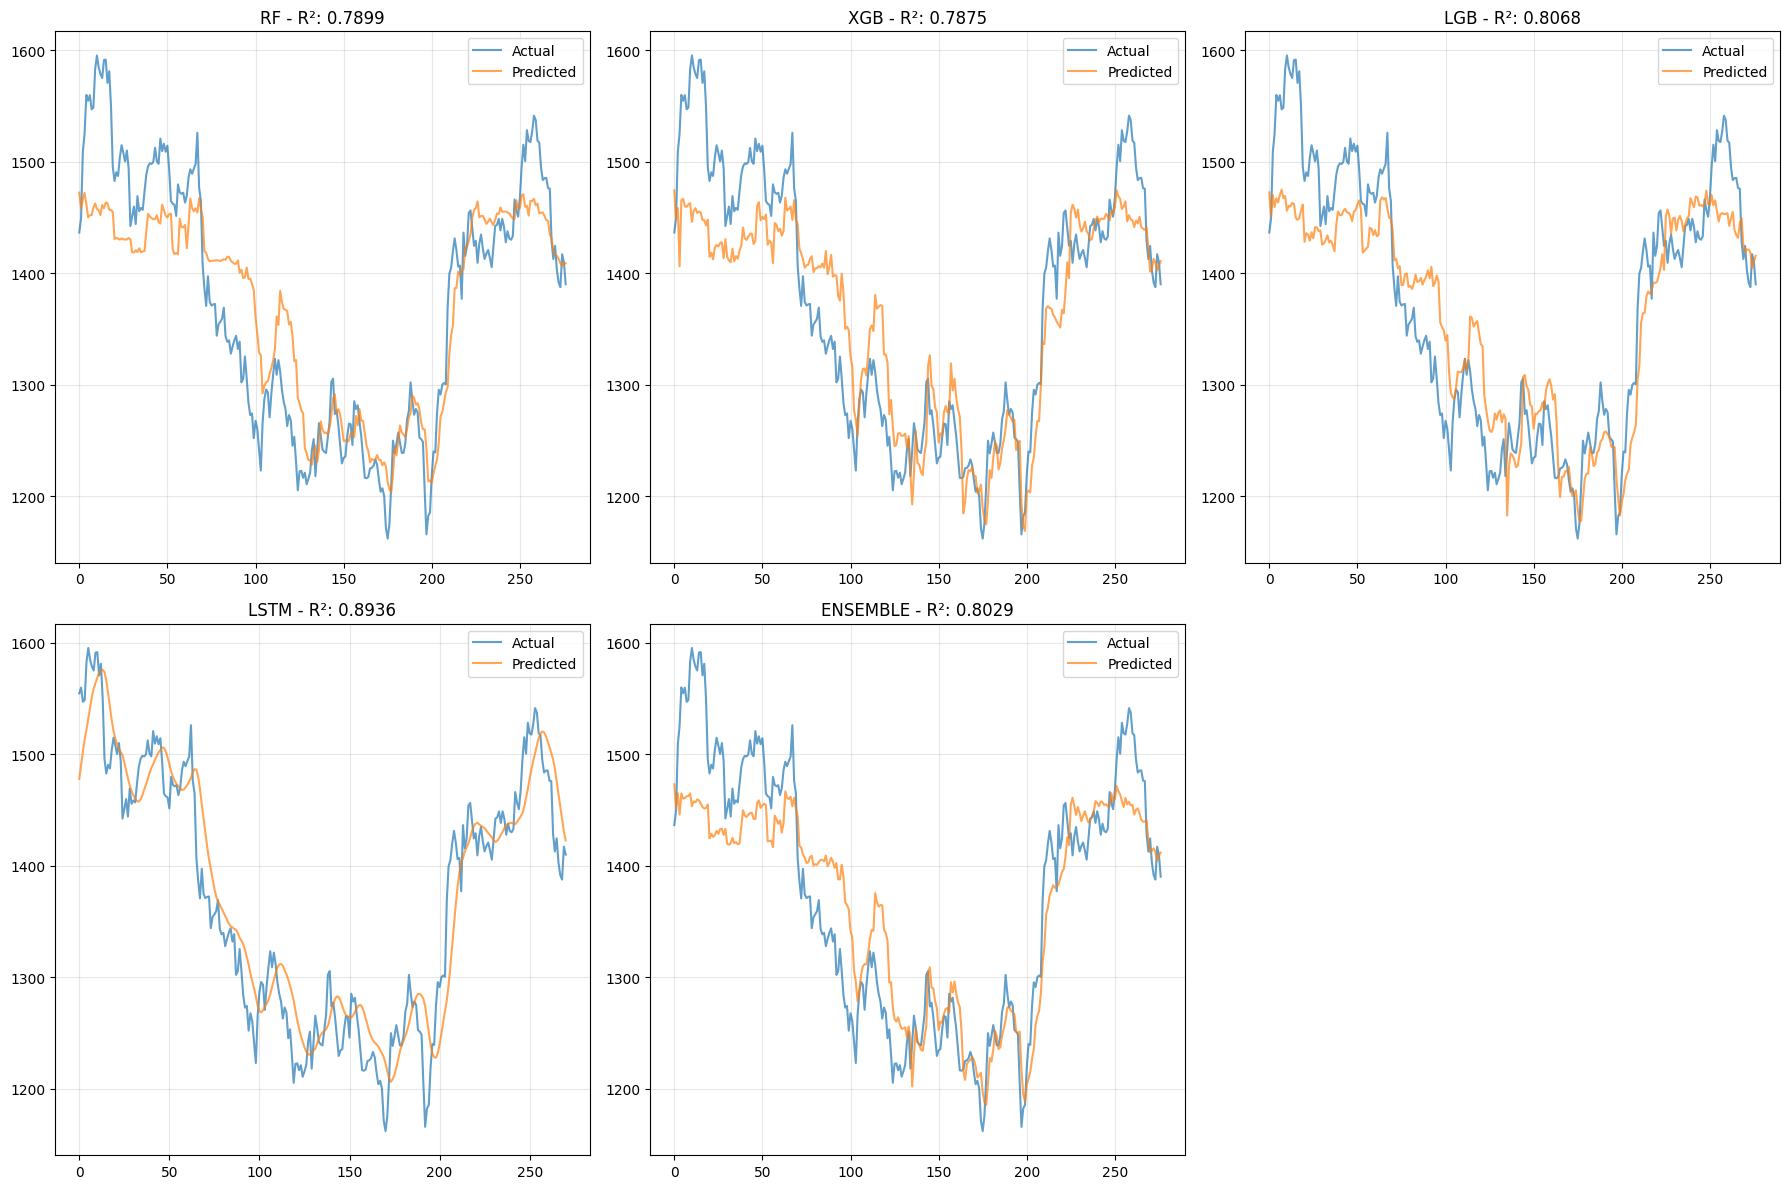


MODEL EVALUATION RESULTS
RF           | R²: 0.7899 | RMSE: 52.42 | MAE: 41.56
XGB          | R²: 0.7875 | RMSE: 52.72 | MAE: 42.91
LGB          | R²: 0.8068 | RMSE: 50.27 | MAE: 41.34
LSTM         | R²: 0.8936 | RMSE: 37.25 | MAE: 29.64
ENSEMBLE     | R²: 0.8029 | RMSE: 50.77 | MAE: 40.82
🎯 Analyzing feature importance...

Top 15 Most Important Features:
             feature  importance
2               MA_5    0.537819
32           High_20    0.188289
4              MA_10    0.080553
6              MA_20    0.058831
17         BB_Middle    0.045969
10            MA_200    0.027706
18          BB_Upper    0.027008
23       MACD_Signal    0.012454
19          BB_Lower    0.005133
8              MA_50    0.003562
21       BB_Position    0.001827
33            Low_20    0.001244
34  Distance_to_High    0.001161
15  Price_MA50_Ratio    0.000814
35   Distance_to_Low    0.000752
💰 Running backtesting...

BACKTESTING RESULTS
RF           | Total Return: 46.57% | vs Buy&Hold: -2.70% | Excess: 

In [15]:
# Enhanced Indian Stock Market Prediction Model
# Includes: Technical Indicators, Ensemble Methods, Backtesting, Cross-validation

# Installation helper function
def install_missing_packages():
    """Install missing packages if needed"""
    import subprocess
    import sys

    packages = {
        'yfinance': 'yfinance',
        'xgboost': 'xgboost',
        'lightgbm': 'lightgbm',
        'tensorflow': 'tensorflow',
        'ta-lib': 'TA-Lib',
        'plotly': 'plotly'
    }

    print("Checking for missing packages...")
    missing = []

    for package, pip_name in packages.items():
        try:
            __import__(package.replace('-', '_'))
        except ImportError:
            missing.append(pip_name)

    if missing:
        print(f"Missing packages: {missing}")
        install = input("Do you want to install missing packages? (y/n): ").lower().strip()
        if install == 'y':
            for package in missing:
                try:
                    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
                    print(f"Successfully installed {package}")
                except Exception as e:
                    print(f"Failed to install {package}: {e}")
    else:
        print("All packages are available!")

# Uncomment the line below if you want to auto-install missing packages
# install_missing_packages()

# Core imports (always available)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Required imports
try:
    import yfinance as yf
except ImportError:
    print("ERROR: yfinance is required. Please install it with: pip install yfinance")
    exit(1)

# Machine Learning imports
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optional imports with fallbacks
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Using GradientBoostingRegressor as fallback.")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available. Using GradientBoostingRegressor as fallback.")

# Deep Learning imports
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not available. LSTM model will be skipped.")

# Technical Analysis imports
try:
    import talib
    TALIB_AVAILABLE = True
except ImportError:
    TALIB_AVAILABLE = False
    print("TA-Lib not available. Using manual calculations for technical indicators.")

# Plotly imports (optional)
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("Plotly not available. Using matplotlib for all visualizations.")

class EnhancedStockPredictor:
    def __init__(self, ticker, start_date="2020-01-01", end_date="2025-08-01"):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.df = None
        self.models = {}
        self.scalers = {}
        self.test_data = {} # Initialize test_data here


    def download_data(self):
        """Download and prepare stock data with fallback options"""
        print(f"Downloading data for {self.ticker}...")

        # Try original ticker first
        self.df = yf.download(self.ticker, start=self.start_date, end=self.end_date, progress=False)

        # If no data, try common variations
        if self.df.empty:
            print(f"No data found for {self.ticker}. Trying variations...")

            # Common Indian stock ticker variations
            variations = []
            base_ticker = self.ticker.replace('.NS', '').replace('.BO', '')

            # Add NSE and BSE variations
            if not self.ticker.endswith('.NS') and not self.ticker.endswith('.BO'):
                variations = [f"{base_ticker}.NS", f"{base_ticker}.BO"]
            elif self.ticker.endswith('.NS'):
                variations = [f"{base_ticker}.BO"]
            elif self.ticker.endswith('.BO'):
                variations = [f"{base_ticker}.NS"]

            # Try variations
            for var_ticker in variations:
                print(f"Trying {var_ticker}...")
                temp_df = yf.download(var_ticker, start=self.start_date, end=self.end_date, progress=False)
                if not temp_df.empty:
                    self.df = temp_df
                    self.ticker = var_ticker
                    print(f"Success! Using {var_ticker}")
                    break

        # If still no data, provide suggestions
        if self.df.empty:
            print(f"\n❌ No data found for {self.ticker}")
            print("\n💡 Suggestions:")
            print("1. Check if the ticker symbol is correct")
            print("2. For NSE stocks, use format: STOCKNAME.NS (e.g., TCS.NS, RELIANCE.NS)")
            print("3. For BSE stocks, use format: STOCKCODE.BO (e.g., 532540.BO for TCS)")
            print("4. Try popular Indian stocks: TCS.NS, RELIANCE.NS, INFY.NS, HDFCBANK.NS")

            # Offer to use a default stock
            use_default = input("\nWould you like to use TCS.NS as an example? (y/n): ").lower().strip()
            if use_default == 'y':
                self.ticker = "TCS.NS"
                print(f"Using {self.ticker} as example...")
                self.df = yf.download(self.ticker, start=self.start_date, end=self.end_date, progress=False)

        if self.df.empty:
            raise ValueError(f"Unable to download data for any ticker variation. Please check your internet connection or try a different stock.")

        # Fix multi-level columns issue
        if isinstance(self.df.columns, pd.MultiIndex):
            # Flatten multi-level columns by keeping only the first level
            self.df.columns = self.df.columns.get_level_values(0)

        # Ensure we have the required columns
        required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        missing_columns = [col for col in required_columns if col not in self.df.columns]

        if missing_columns:
            print(f"⚠️  Warning: Missing columns: {missing_columns}")
            # Try alternative column names
            if 'Adj Close' in self.df.columns and 'Close' not in self.df.columns:
                self.df['Close'] = self.df['Adj Close']

        # Remove any NaN rows
        self.df.dropna(inplace=True)

        print(f"✅ Downloaded {len(self.df)} trading days of data for {self.ticker}")
        print(f"📊 Available columns: {list(self.df.columns)}")
        return self.df

    def add_technical_indicators(self):
        """Add comprehensive technical indicators"""
        global TALIB_AVAILABLE # Declare as global

        df = self.df.copy()

        # Ensure we have numeric data and handle any data type issues
        numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Remove any remaining NaN values
        df.dropna(inplace=True)

        # Basic price features
        df['Returns'] = df['Close'].pct_change()
        df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

        # Moving Averages
        for period in [5, 10, 20, 50, 200]:
            df[f'MA_{period}'] = df['Close'].rolling(window=period, min_periods=1).mean()
            if 'Volume' in df.columns:
                df[f'Volume_MA_{period}'] = df['Volume'].rolling(window=period, min_periods=1).mean()

        # Volatility
        df['Volatility_20'] = df['Returns'].rolling(window=20, min_periods=1).std()
        df['Volatility_50'] = df['Returns'].rolling(window=50, min_periods=1).std()

        # Price relative to moving averages (ensure no division issues)
        df['Price_MA20_Ratio'] = df['Close'] / df['MA_20'].replace(0, np.nan)
        df['Price_MA50_Ratio'] = df['Close'] / df['MA_50'].replace(0, np.nan)

        if TALIB_AVAILABLE and len(df) > 0:
            try:
                # Convert to numpy arrays for TA-Lib
                high_prices = df['High'].values.astype(float)
                low_prices = df['Low'].values.astype(float)
                close_prices = df['Close'].values.astype(float)
                volume_data = df['Volume'].values.astype(float) if 'Volume' in df.columns else None

                # RSI
                df['RSI'] = talib.RSI(close_prices, timeperiod=14)

                # MACD
                macd, macd_signal, macd_hist = talib.MACD(close_prices)
                df['MACD'] = macd
                df['MACD_Signal'] = macd_signal
                df['MACD_Hist'] = macd_hist

                # Bollinger Bands
                bb_upper, bb_middle, bb_lower = talib.BBANDS(close_prices, timeperiod=20)
                df['BB_Upper'] = bb_upper
                df['BB_Middle'] = bb_middle
                df['BB_Lower'] = bb_lower
                df['BB_Width'] = (bb_upper - bb_lower) / bb_middle
                df['BB_Position'] = (close_prices - bb_lower) / (bb_upper - bb_lower)

                # Additional indicators
                df['ADX'] = talib.ADX(high_prices, low_prices, close_prices)
                df['CCI'] = talib.CCI(high_prices, low_prices, close_prices)
                df['Williams_R'] = talib.WILLR(high_prices, low_prices, close_prices)
                df['Stoch_K'], df['Stoch_D'] = talib.STOCH(high_prices, low_prices, close_prices)

            except Exception as e:
                print(f"⚠️  TA-Lib calculation error: {e}. Using manual calculations...")
                TALIB_AVAILABLE = False # Modify the global variable

        if not TALIB_AVAILABLE:
            # Manual calculations for key indicators
            try:
                # RSI
                delta = df['Close'].diff()
                gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
                loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
                rs = gain / loss.replace(0, np.nan)
                df['RSI'] = 100 - (100 / (1 + rs))

                # Bollinger Bands
                df['BB_Middle'] = df['Close'].rolling(window=20, min_periods=1).mean()
                bb_std = df['Close'].rolling(window=20, min_periods=1).std()
                df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
                df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
                df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle'].replace(0, np.nan)
                df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower']).replace(0, np.nan)

                # Simple MACD
                ema_12 = df['Close'].ewm(span=12, min_periods=1).mean()
                ema_26 = df['Close'].ewm(span=26, min_periods=1).mean()
                df['MACD'] = ema_12 - ema_26
                df['MACD_Signal'] = df['MACD'].ewm(span=9, min_periods=1).mean()
                df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

            except Exception as e:
                print(f"⚠️  Manual calculation error: {e}")

        # Market timing features
        df['Day_of_Week'] = df.index.dayofweek
        df['Month'] = df.index.month
        df['Quarter'] = df.index.quarter
        df['Is_Month_End'] = df.index.is_month_end.astype(int)
        df['Is_Quarter_End'] = df.index.is_quarter_end.astype(int)

        # Volume indicators (if volume data available)
        if 'Volume' in df.columns:
            df['Volume_Ratio'] = df['Volume'] / df['Volume_MA_20'].replace(0, np.nan)
            df['Price_Volume'] = df['Close'] * df['Volume']
        else:
            print("⚠️  Volume data not available. Skipping volume-based indicators.")
            df['Volume_Ratio'] = 0
            df['Price_Volume'] = 0

        # Support and Resistance levels
        if 'High' in df.columns and 'Low' in df.columns:
            df['High_20'] = df['High'].rolling(window=20, min_periods=1).max()
            df['Low_20'] = df['Low'].rolling(window=20, min_periods=1).min()
            df['Distance_to_High'] = (df['High_20'] - df['Close']) / df['Close'].replace(0, np.nan)
            df['Distance_to_Low'] = (df['Close'] - df['Low_20']) / df['Close'].replace(0, np.nan)
        else:
            df['High_20'] = df['Close']
            df['Low_20'] = df['Close']
            df['Distance_to_High'] = 0
            df['Distance_to_Low'] = 0

        # Fill any remaining NaN values with forward fill, then backward fill
        df.fillna(method='ffill', inplace=True)
        df.fillna(method='bfill', inplace=True)
        df.fillna(0, inplace=True)  # Fill any remaining NaN with 0

        # Replace infinite values
        df.replace([np.inf, -np.inf], 0, inplace=True)

        self.df = df
        print(f"✅ Added technical indicators. Dataset now has {len(df.columns)} features")
        print(f"📊 Data shape: {df.shape}")

        return df

    def get_fundamental_data(self):
        """Attempt to get fundamental data"""
        try:
            stock_info = yf.Ticker(self.ticker)
            info = stock_info.info

            # Extract key fundamental ratios if available
            fundamentals = {}
            fund_keys = ['trailingPE', 'forwardPE', 'priceToBook', 'debtToEquity',
                        'returnOnEquity', 'returnOnAssets', 'currentRatio', 'quickRatio']

            for key in fund_keys:
                if key in info and info[key] is not None:
                    fundamentals[key] = info[key]

            if fundamentals:
                print(f"Retrieved fundamental data: {list(fundamentals.keys())}")
                # Add as constant columns (they change infrequently)
                for key, value in fundamentals.items():
                    self.df[f'Fund_{key}'] = value
            else:
                print("No fundamental data available")

        except Exception as e:
            print(f"Could not retrieve fundamental data: {e}")

    def prepare_features(self, target_days_ahead=1):
        """Prepare features and target variable"""
        # Create target variable
        self.df['Target'] = self.df['Close'].shift(-target_days_ahead)

        # Remove rows with NaN values
        self.df.dropna(inplace=True)

        # Select feature columns (exclude OHLCV and target)
        exclude_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Target']
        feature_cols = [col for col in self.df.columns if col not in exclude_cols]

        print(f"Using {len(feature_cols)} features for prediction")
        print("Features:", feature_cols[:10], "..." if len(feature_cols) > 10 else "")

        return feature_cols

    def create_sequences(self, data, sequence_length):
        """Create sequences for LSTM"""
        X, y = [], []
        for i in range(sequence_length, len(data)):
            X.append(data[i-sequence_length:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    def time_series_cv(self, X, y, n_splits=5):
        """Perform time series cross-validation"""
        tscv = TimeSeriesSplit(n_splits=n_splits)
        cv_scores = []

        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Quick Random Forest for CV
            rf = RandomForestRegressor(n_estimators=50, random_state=42)
            rf.fit(X_train, y_train)
            pred = rf.predict(X_val)
            score = r2_score(y_val, pred)
            cv_scores.append(score)

        return cv_scores

    def train_models(self, feature_cols):
        """Train multiple models"""
        X = self.df[feature_cols].values
        y = self.df['Target'].values

        # Split data (80% train, 20% test)
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        self.scalers['standard'] = scaler

        # Time Series Cross-validation
        print("Performing time series cross-validation...")
        cv_scores = self.time_series_cv(X_train, y_train)
        print(f"CV R² scores: {cv_scores}")
        print(f"Mean CV R² score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

        # 1. Random Forest
        print("Training Random Forest...")
        rf = RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train_scaled, y_train)
        self.models['rf'] = rf

        # 2. XGBoost or Gradient Boosting fallback
        if XGBOOST_AVAILABLE:
            print("Training XGBoost...")
            xgb_model = xgb.XGBRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1
            )
            xgb_model.fit(X_train_scaled, y_train)
            self.models['xgb'] = xgb_model
        else:
            print("Training Gradient Boosting (XGBoost fallback)...")
            gb_model = GradientBoostingRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42
            )
            gb_model.fit(X_train_scaled, y_train)
            self.models['xgb'] = gb_model

        # 3. LightGBM or Gradient Boosting fallback
        if LIGHTGBM_AVAILABLE:
            print("Training LightGBM...")
            lgb_model = lgb.LGBMRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1,
                verbose=-1
            )
            lgb_model.fit(X_train_scaled, y_train)
            self.models['lgb'] = lgb_model
        else:
            print("Training Gradient Boosting (LightGBM fallback)...")
            gb_model2 = GradientBoostingRegressor(
                n_estimators=150,
                max_depth=5,
                learning_rate=0.15,
                random_state=43
            )
            gb_model2.fit(X_train_scaled, y_train)
            self.models['lgb'] = gb_model2

        # 4. LSTM (if TensorFlow is available)
        if TENSORFLOW_AVAILABLE:
            print("Training LSTM...")
            lstm_scaler = MinMaxScaler()
            lstm_data = lstm_scaler.fit_transform(self.df[['Close']].values)
            self.scalers['lstm'] = lstm_scaler

            sequence_length = 30
            X_lstm, y_lstm = self.create_sequences(lstm_data, sequence_length)

            # Split LSTM data
            split_lstm = int(len(X_lstm) * 0.8)
            X_lstm_train = X_lstm[:split_lstm]
            X_lstm_test = X_lstm[split_lstm:]
            y_lstm_train = y_lstm[:split_lstm]
            y_lstm_test = y_lstm[split_lstm:]

            # Build LSTM model
            lstm_model = Sequential([
                LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
                Dropout(0.2),
                LSTM(50, return_sequences=False),
                Dropout(0.2),
                Dense(25),
                Dense(1)
            ])

            lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            history = lstm_model.fit(
                X_lstm_train, y_lstm_train,
                epochs=50,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )

            self.models['lstm'] = lstm_model

            # Store LSTM test data
            self.test_data['X_lstm_test'] = X_lstm_test
            self.test_data['y_lstm_test'] = y_lstm_test
        else:
            print("TensorFlow not available. Skipping LSTM model...")
            # Create dummy LSTM test data to avoid errors
            self.test_data['X_lstm_test'] = None
            self.test_data['y_lstm_test'] = None

        # 5. Ensemble Model
        print("Creating Ensemble Model...")
        ensemble = VotingRegressor([
            ('rf', rf),
            ('xgb', self.models['xgb']), # Use self.models['xgb'] to handle fallback
            ('lgb', self.models['lgb'])  # Use self.models['lgb'] to handle fallback
        ])
        ensemble.fit(X_train_scaled, y_train)
        self.models['ensemble'] = ensemble

        # Store test data for evaluation
        self.test_data['X_test'] = X_test_scaled
        self.test_data['y_test'] = y_test


        print("All models trained successfully!")

    def evaluate_models(self):
        """Evaluate all trained models"""
        results = {}

        for name, model in self.models.items():
            if name == 'lstm' and TENSORFLOW_AVAILABLE and self.test_data.get('X_lstm_test') is not None:
                predictions = model.predict(self.test_data['X_lstm_test'])
                predictions = self.scalers['lstm'].inverse_transform(predictions)
                y_true = self.scalers['lstm'].inverse_transform(self.test_data['y_lstm_test'])
            elif name == 'lstm':
                # Skip LSTM if not available
                continue
            else:
                predictions = model.predict(self.test_data['X_test'])
                y_true = self.test_data['y_test']

            # Calculate metrics
            mse = mean_squared_error(y_true, predictions)
            mae = mean_absolute_error(y_true, predictions)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_true, predictions)

            results[name] = {
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2,
                'predictions': predictions.flatten(),
                'y_true': y_true.flatten()
            }

        return results

    def plot_results(self, results):
        """Plot model predictions vs actual values"""
        n_models = len(results)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()

        for i, (model_name, result) in enumerate(results.items()):
            if i < len(axes):
                ax = axes[i]
                ax.plot(result['y_true'], label='Actual', alpha=0.7)
                ax.plot(result['predictions'], label='Predicted', alpha=0.7)
                ax.set_title(f'{model_name.upper()} - R²: {result["R2"]:.4f}')
                ax.legend()
                ax.grid(True, alpha=0.3)

        # Hide extra subplots
        for i in range(len(results), len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.show()

        # Results summary
        print("\n" + "="*60)
        print("MODEL EVALUATION RESULTS")
        print("="*60)
        for name, result in results.items():
            print(f"{name.upper():<12} | R²: {result['R2']:.4f} | RMSE: {result['RMSE']:.2f} | MAE: {result['MAE']:.2f}")

    def backtest_strategy(self, results, initial_capital=100000):
        """Simple backtesting framework"""
        print("\n" + "="*60)
        print("BACKTESTING RESULTS")
        print("="*60)

        # Get actual prices for backtesting period
        test_start_idx = len(self.df) - len(results['ensemble']['y_true'])
        actual_prices = self.df['Close'].iloc[test_start_idx:].values

        backtest_results = {}

        for model_name, result in results.items():
            if model_name == 'lstm':
                continue  # Skip LSTM for simplicity in backtesting

            predictions = result['predictions']
            returns = []
            positions = []
            capital = initial_capital
            shares = 0

            for i in range(1, len(predictions)):
                # Simple strategy: buy if predicted price > current price, sell otherwise
                predicted_return = (predictions[i] - actual_prices[i-1]) / actual_prices[i-1]

                if predicted_return > 0.01:  # Buy signal (>1% predicted gain)
                    if shares == 0:  # Buy
                        shares = capital / actual_prices[i-1]
                        capital = 0
                        positions.append('BUY')
                    else:
                        positions.append('HOLD')
                elif predicted_return < -0.01:  # Sell signal (<-1% predicted loss)
                    if shares > 0:  # Sell
                        capital = shares * actual_prices[i-1]
                        shares = 0
                        positions.append('SELL')
                    else:
                        positions.append('HOLD')
                else:
                    positions.append('HOLD')

                # Calculate current portfolio value
                current_value = capital + (shares * actual_prices[i])
                returns.append((current_value - initial_capital) / initial_capital)

            # Final portfolio value
            final_value = capital + (shares * actual_prices[-1])
            total_return = (final_value - initial_capital) / initial_capital

            # Buy and hold return for comparison
            buy_hold_return = (actual_prices[-1] - actual_prices[0]) / actual_prices[0]

            backtest_results[model_name] = {
                'total_return': total_return,
                'buy_hold_return': buy_hold_return,
                'excess_return': total_return - buy_hold_return,
                'final_value': final_value,
                'positions': positions
            }

            print(f"{model_name.upper():<12} | Total Return: {total_return:.2%} | vs Buy&Hold: {buy_hold_return:.2%} | Excess: {(total_return-buy_hold_return):.2%}")

        return backtest_results

    def get_feature_importance(self):
        """Get feature importance from tree-based models"""
        if 'rf' in self.models:
            # Ensure feature_cols are determined after all additions
            exclude_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Target']
            feature_cols = [col for col in self.df.columns if col not in exclude_cols]

            importances = self.models['rf'].feature_importances_
            feature_importance = pd.DataFrame({
                'feature': feature_cols,
                'importance': importances
            }).sort_values('importance', ascending=False)

            print("\nTop 15 Most Important Features:")
            print(feature_importance.head(15))

            return feature_importance

    def predict_next_price(self):
        """Predict next day's price using ensemble"""
        if 'ensemble' not in self.models or 'standard' not in self.scalers:
            print("Ensemble model or scaler not trained!")
            return None, None

        # Get last row of features
        exclude_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Target']
        feature_cols = [col for col in self.df.columns if col not in exclude_cols]

        # Ensure self.df has enough data for prediction after dropping NaNs
        if len(self.df) < 1:
             print("Not enough data to make a prediction.")
             return None, None

        last_features = self.df[feature_cols].iloc[-1:].values

        try:
            last_features_scaled = self.scalers['standard'].transform(last_features)
        except Exception as e:
             print(f"Error scaling features for prediction: {e}")
             # Handle potential mismatch in feature count if data was dropped unexpectedly
             if last_features.shape[1] != len(feature_cols):
                  print(f"Mismatch in feature count: Expected {len(feature_cols)}, got {last_features.shape[1]}")
             return None, None


        # Predict using ensemble
        next_price = self.models['ensemble'].predict(last_features_scaled)[0]
        current_price = self.df['Close'].iloc[-1]
        predicted_return = (next_price - current_price) / current_price

        print(f"\nPREDICTION FOR NEXT TRADING DAY:")
        print(f"Current Price: ₹{current_price:.2f}")
        print(f"Predicted Price: ₹{next_price:.2f}")
        print(f"Predicted Return: {predicted_return:.2%}")

        return next_price, predicted_return

def get_popular_indian_stocks():
    """Return a list of popular Indian stocks with their tickers"""
    return {
        'TCS': 'TCS.NS',
        'Reliance': 'RELIANCE.NS',
        'Infosys': 'INFY.NS',
        'HDFC Bank': 'HDFCBANK.NS',
        'ICICI Bank': 'ICICIBANK.NS',
        'Wipro': 'WIPRO.NS',
        'ITC': 'ITC.NS',
        'Axis Bank': 'AXISBANK.NS',
        'Kotak Bank': 'KOTAKBANK.NS',
        'HUL': 'HINDUUNILVR.NS',
        'Maruti': 'MARUTI.NS',
        'Asian Paints': 'ASIANPAINT.NS',
        'Bajaj Finance': 'BAJFINANCE.NS',
        'SBI': 'SBIN.NS',
        'L&T': 'LT.NS'
    }

def validate_and_suggest_ticker(ticker):
    """Validate ticker and provide suggestions"""
    if not ticker:
        return None

    ticker = ticker.upper().strip()

    # If user enters just company name, try to match
    popular_stocks = get_popular_indian_stocks()

    # Direct name match
    for name, symbol in popular_stocks.items():
        if ticker.upper() in name.upper() or name.upper() in ticker.upper():
            return symbol

    # If already in correct format, return as is
    if ticker.endswith('.NS') or ticker.endswith('.BO'):
        return ticker

    # Default to NSE if no suffix
    return f"{ticker}.NS"

def run_enhanced_prediction(): # Added definition for run_enhanced_prediction
    """Main function to run the enhanced prediction model"""

    # User inputs
    print("Enhanced Indian Stock Market Prediction Model")
    print("=" * 50)

    ticker = input("Enter NSE/BSE stock ticker (e.g., TCS.NS, RELIANCE.NS): ").strip()
    if not ticker:
        ticker = "TCS.NS"  # Default

    # Initialize predictor
    predictor = EnhancedStockPredictor(ticker)

    try:
        # Step 1: Download data
        predictor.download_data()

        # Check if we have enough data
        if len(predictor.df) < 100:
            print(f"⚠️  Warning: Only {len(predictor.df)} days of data available.")
            print("Model performance may be limited with insufficient data.")

            proceed = input("Continue anyway? (y/n): ").lower().strip()
            if proceed != 'y':
                print("Analysis cancelled.")
                return

        # Step 2: Add technical indicators
        print("\n📊 Adding technical indicators...")
        predictor.add_technical_indicators()

        # Step 3: Get fundamental data
        print("📈 Fetching fundamental data...")
        predictor.get_fundamental_data()

        # Step 4: Prepare features
        print("🔧 Preparing features...")
        feature_cols = predictor.prepare_features()

        # Step 5: Train models
        print("🤖 Training models...")
        predictor.train_models(feature_cols)

        # Step 6: Evaluate models
        print("📋 Evaluating models...")
        results = predictor.evaluate_models()

        # Step 7: Plot results
        print("📈 Plotting results...")
        predictor.plot_results(results)

        # Step 8: Feature importance
        print("🎯 Analyzing feature importance...")
        predictor.get_feature_importance()

        # Step 9: Backtesting
        print("💰 Running backtesting...")
        backtest_results = predictor.backtest_strategy(results)

        # Step 10: Next day prediction
        print("🔮 Making next day prediction...")
        predictor.predict_next_price()

        print("\n🎉 Analysis completed successfully!")

    except Exception as e:
        print(f"\n❌ Error occurred: {e}")
        print("\n🔧 Troubleshooting tips:")
        print("1. Check your internet connection")
        print("2. Verify the stock ticker is correct")
        print("3. Try a popular stock like TCS.NS or RELIANCE.NS")
        print("4. Make sure you have the required packages installed")

        # Show detailed error for debugging
        import traceback
        print(f"\n📝 Detailed error (for debugging):")
        traceback.print_exc()

# Run the enhanced model
if __name__ == "__main__":
    run_enhanced_prediction()